# Test/Debuger for the predict.py file

# TODO 
1. evaluation metrics - IOU for the mask 
2. can do this on a single image to start
3. evaluation at scale: create another dataloader; creates batches; apply your model to a batch; extract the eval metrics

In [26]:
import os
import torch
import segmentation_models_pytorch as smp
import yaml
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import json
from PIL import Image, ImageOps

In [4]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
# Define the transformation to apply to the image
transform = Compose([
    Resize((224, 224)), ToTensor(),  # Convert the image to a tensor
])

In [6]:
# Load the config file
config_path = '../runs/unet_smp/demo_run/config/config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Extract values from the config
checkpoint_path = os.path.join(config['path_checkpoints'], 'checkpoint_epoch100.pth')
data_root = config['path_data']
image_size = config['image_size']
in_channels = config['in_channels']
out_channels = config['out_channels']
encoder_name = config['encoder_name']
encoder_weights = config['encoder_weights']
image_folder = os.path.join(config['path_data'], 'images')

In [8]:
# Load the pre-trained model with checkpoint
model = smp.Unet(
    encoder_name=encoder_name,                   # Encoder architecture, e.g., resnet34
    encoder_weights=encoder_weights,             # Pre-trained weights from ImageNet
    in_channels=in_channels,                     # Number of input channels (3 for RGB)
    out_channels=out_channels,                   # Number of output channels (1 for binary)
    activation='sigmoid'                         # Sigmoid activation for binary segmentation
)
model = model.to(device)

In [ ]:
# Create a custom dataset for validation
annotations_path = os.path.join(data_root, 'annotations/val.json')

with open(annotations_path) as f:
    annotations = json.load(f)

# Extract relevant parts of the annotations
image_annotations = {annotation['image_id']: annotation for annotation in annotations['annotations']}
image_info = {image['id']: image for image in annotations['images']}

# Load the model weights from checkpoint
model.load_state_dict(torch.load(checkpoint_path))
model.eval()  # Set the model to evaluation mode

In [28]:
# Padding function - think about resizing (224, 224)
def pad_to_divisible(image, divisor=32):
    width, height = image.size # extract current dims of image
    pad_width = (divisor - width % divisor) % divisor
    pad_height = (divisor - height % divisor) % divisor
    padding = (0, 0, pad_width, pad_height)  # Right and bottom padding
    padded_image = Image.new('RGB', (width + pad_width, height + pad_height))
    padded_image.paste(image, (0, 0))  # Paste original image on top-left corner
    return padded_image

# Function to get the annotation for an image by its ID
def get_annotation_by_image_id(image_id):
    return image_annotations.get(image_id, None)

# Function to predict based on an image (DEBUGGING HERE)
def predict(image_path, transform, model, device):
    image = Image.open(image_path).convert("RGB") # open image
    #image = pad_to_divisible(image, divisor=32) # pad to div by 32
    image_tensor = transform(image).unsqueeze(0).to(device)  # apply transformation
    
    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)  # Forward pass
    
    # Sigmoid for binary segmentation (if required)
    output_mask = torch.sigmoid(output).squeeze().cpu().numpy()  # Move output back to CPU for visualization
    
    return output, output_mask


In [41]:
# Example usage
#image_path = '/mnt/class_data/group2/alexandradigiacomo/dataset/images/07252023PANB0201.JPG'
image_path ='/mnt/class_data/group2/alexandradigiacomo/dataset/images/07202023PANB0201.JPG'

output, output_mask = predict(image_path, transform, model, device)


In [ ]:
# use dataloader to import an image and see what you get 
# see range of masks for display problems

In [42]:
output_display = output.cpu().squeeze().numpy()
output_display*255

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.0572310e-34, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.5567805e-08, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], shape=(224, 224), dtype=float32)

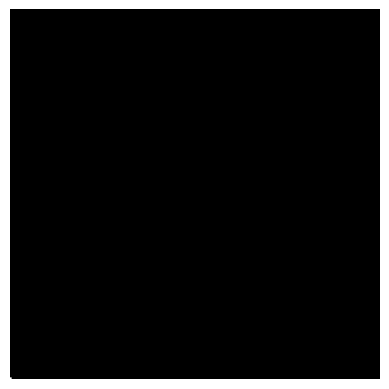

In [43]:
# Example visualization
output_mask_display = output_mask
# mask plot

plt.imshow(output_display, cmap='gray')  # Use 'gray' colormap for mask
plt.axis('off') 

plt.show()